<a href="https://colab.research.google.com/github/weldlabucsb/mcmc/blob/master/mcmc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [170]:
#Goal of this notebook is to create some simple code that can take a 1d array which we will suppose we have, i.e. it will be one of the inputs
#and we will take it and compare it to simulated data.

## Imports:

import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from scipy.integrate import odeint
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp
from multiprocessing import Process, Queue
import time
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize

class _TFColor(object):
    """Enum of colors used in TF docs."""
    red = '#F15854'
    blue = '#5DA5DA'
    orange = '#FAA43A'
    green = '#60BD68'
    pink = '#F17CB0'
    brown = '#B2912F'
    purple = '#B276B2'
    yellow = '#DECF3F'
    gray = '#4D4D4D'
    def __getitem__(self, i):
        return [
            self.red,
            self.orange,
            self.green,
            self.blue,
            self.pink,
            self.brown,
            self.purple,
            self.yellow,
            self.gray,
        ][i % 9]
TFColor = _TFColor()

tfd = tfp.distributions

In [95]:
#@title Tensors Tests
tf.tile([1./3,1./3,1./3], [2,])
tf.ones((2,3))*tf.constant([1./3,1./3,1./3])
amplitude = tf.constant([1., 2.])
tf.ones((3, tf.shape(amplitude)[0]))*amplitude 
pixels = tf.cast(tf.range(0, 100), dtype=tf.float32)
test = tfd.Normal(loc = [2., 5.], scale = [2., 0.5])
tf.transpose(amplitude*tf.ones((100, 2)))*tf.reshape(test.prob(tf.reshape(tf.ones(( 2, tf.shape(pixels)[0]))*pixels, (tf.shape(pixels)[0], 2))), (2,100))
# test.prob(tf.ones(( 2, tf.shape(pixels)[0]))*pixels)

<tf.Tensor: shape=(2, 100), dtype=float32, numpy=
array([[1.2098535e-01, 1.0104537e-14, 1.9947115e-01, 2.6766057e-04,
        1.2098535e-01, 7.9788458e-01, 2.6995480e-02, 2.6766057e-04,
        2.2159240e-03, 1.0104537e-14, 6.6915141e-05, 4.2927658e-32,
        7.4336003e-07, 0.0000000e+00, 3.0379428e-09, 0.0000000e+00,
        4.5673621e-12, 0.0000000e+00, 2.5261318e-15, 0.0000000e+00,
        5.1398796e-19, 0.0000000e+00, 3.8472939e-23, 0.0000000e+00,
        1.0594082e-27, 0.0000000e+00, 1.0731945e-32, 0.0000000e+00,
        3.9994241e-38, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00

# Global Constants

In [81]:
# number of "pixels" on the direction
N = 100

# Definitions of the distributions

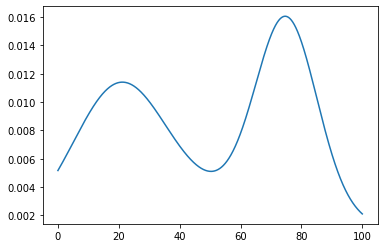

In [117]:
def main_gaussian(sigma_right, sigma_left, sigma_center, lambda_right, lambda_left, lambda_center):
  center_dist = tfd.Normal(loc = lambda_center, scale = sigma_center)
  # print(sigma_right)
  try:
    pass
    # print(sigma_right.shape)
  except:
    pass
  left_dist = tfd.Normal(loc = lambda_left, scale = sigma_left)
  right_dist = tfd.Normal(loc = lambda_right, scale = sigma_right)
  try:
    return tfd.Mixture(cat=tfd.Categorical(probs=tf.ones((tf.shape(sigma_right)[0],3))*tf.constant([1./3,1./3,1./3])),
  components=[
    center_dist,
    left_dist,
    right_dist
  ])
  except:
    return tfd.Mixture(cat=tfd.Categorical(probs=[1./3,1./3,1./3]),
  components=[
    center_dist,
    left_dist,
    right_dist
  ])

#test:
N = 100.
x = tf.linspace(0., N*1, int(1e4))
plt.plot(x, main_gaussian(15,10,40, 20, 75,50).prob(x));


### Joint Distribution

In [141]:
#first try of function:
#we assume as explained on my onenote doc, a 3 piece gaussian.



# def od_sim_left_1d(pixel, ):
def joint_dist_gen(amplitude, sigmas, sigma_right, sigma_left, sigma_center,
                   lambda_right, lambda_left,
                   lambda_center, N):
  #we assume that each pixel is going to follow a normal distribution with the average given (lambda_i) given by what OD we expect from the "parrent" gaussians.
  mix = main_gaussian(sigma_right, sigma_left, sigma_center, lambda_right, lambda_left, lambda_center)
  pixels = tf.range(0, limit=N, delta=1.)
  try:
    amp = tf.transpose(tf.ones((tf.shape(pixels)[0], tf.shape(amplitude)[0]))*amplitude)
    # amp = amplitude
    pixels = pixels*tf.ones((mix.batch_shape[0], tf.shape(pixels)[0]))
    probs = tf.reshape(mix.prob(tf.reshape(pixels, (N, mix.batch_shape[0]))), (mix.batch_shape[0], N))
    # print("pixels shape ", pixels.shape)
    #print("amp ", amp)
  except:
    amp = amplitude
    probs = mix.prob(pixels)
    # print("test")
  # print("mix shape", mix.batch_shape)
    
  # print("prob shape", probs.shape)
  # print(amp.shape)
  density = probs*amp #N sized tensor with the OD density of each pixel.
  #simulated distribution:
  #assume a poissonian dist for the # of counts:
  #tfd.Poisson(rate=density)
  #assume a normal distribution:
  return tfd.Normal(loc = density, scale=sigmas)

def closed_joint_dist_gen(N):
  #second = lambda r0, gamma, delta, I0, R0, care: self.joint_dist_gen_tr(r0, gamma, I0, R0, care, delta)
  first = [# x_tail
    tfd.Uniform(low=0., high=1.*N),
    #lambda_center
    lambda x: tfd.Uniform(low=N/2.-x, high=N/2.+x),
    #lambda_left
    lambda lambda_center, x: tfd.Uniform(low=0., high=N/2.-x),
    #lambda_right:
    lambda lambda_left, lambda_center, x: tfd.Uniform(low = N/2.+x, high=N),
    #sigma_center
    tfd.Uniform(low = 0., high = 1.),
    #sigma_left
    tfd.Uniform(low = 0., high = 1.),
    #sigma_right
    tfd.Uniform(low = 0., high = 1.),
    #production of the N scales of the N pixels:
    tfd.Independent(tfd.Uniform(low = 0.*tf.ones((N,)), high = 1.*tf.ones((N,))), reinterpreted_batch_ndims=1),
    #amplitude
    tfd.Normal(loc=1., scale=0.5)
    ]
    
  
  return tfd.JointDistributionSequential(first+[
    # likelihood
    #   Using Independent to ensure the log_prob is not incorrectly broadcasted
    lambda amplitude , sigmas, sigma_right, sigma_left, sigma_center, lambda_right, lambda_left, lambda_center: #tfd.Independent(
    tfd.Independent(
        joint_dist_gen(amplitude, sigmas, sigma_right, sigma_left, sigma_center, lambda_right, lambda_left, lambda_center, N),#) #,
        reinterpreted_batch_ndims=1)
    #), reinterpreted_batch_ndims=1)
    ,
    #lambda _, care, R0, I0, delta, gamma, r0: tfd.Poisson(rate=np.float32(care*self.Z))
    ])
dist = closed_joint_dist_gen(100)
dist.resolve_graph()

(('x', ()),
 ('lambda_center', ('x',)),
 ('lambda_left', ('lambda_center', 'x')),
 ('lambda_right', ('lambda_left', 'lambda_center', 'x')),
 ('sigma_center', ()),
 ('sigma_left', ()),
 ('sigma_right', ()),
 ('sigmas', ()),
 ('amplitude', ()),
 ('x1',
  ('amplitude',
   'sigmas',
   'sigma_right',
   'sigma_left',
   'sigma_center',
   'lambda_right',
   'lambda_left',
   'lambda_center')))

In [147]:
sm = dist.sample()
sm

[<tf.Tensor: shape=(), dtype=float32, numpy=20.689535>,
 <tf.Tensor: shape=(), dtype=float32, numpy=29.332184>,
 <tf.Tensor: shape=(), dtype=float32, numpy=13.706285>,
 <tf.Tensor: shape=(), dtype=float32, numpy=97.33265>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.037354827>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.11924994>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.56203985>,
 <tf.Tensor: shape=(100,), dtype=float32, numpy=
 array([0.5378003 , 0.43373168, 0.4505    , 0.31671083, 0.80298305,
        0.41707516, 0.8261064 , 0.8553922 , 0.63771915, 0.78866637,
        0.33386815, 0.61364424, 0.21225715, 0.18499279, 0.6765022 ,
        0.18014657, 0.75396883, 0.53522444, 0.97033167, 0.82831335,
        0.5864692 , 0.7145835 , 0.51841986, 0.8330029 , 0.6962609 ,
        0.6806638 , 0.09186745, 0.5739355 , 0.48853588, 0.57064176,
        0.8069316 , 0.6711159 , 0.8636261 , 0.10735381, 0.20186639,
        0.92575634, 0.05894363, 0.43990326, 0.69244146, 0.37673283,
        0.32

In [149]:
#sample the joint distribution:
dist.log_prob(sm)

<tf.Tensor: shape=(), dtype=float32, numpy=-68.820755>

# Data Import

We will take some data and turn it a 1d array with the data along a given direction.

The idea is that the data is a 2d matrix, we will interpolate it to get a function OD(x, y) that will provide the optical density at pixels x,y. We want to be able to slice it, so that we give a direction like \[0,1] or \[1,1] and with N bins. Each bin would represent a pixel. 

We have used the DataManager made by Peter to get a CSV file that I will use for this run.

Load the optical density (could add some kind of interworking with matlab maybe).

All of the od < 0 should be equal to 0.

In [68]:
#load csv file:
od = np.loadtxt(r"/content/drive/My Drive/Colab Notebooks/Weld Lab/data/optical density run 18.csv", delimiter=",", encoding='utf-8-sig').T
od[od < 0] = 0 #isn't this so easy with numpy?? How do you even do the same on matlab? Is it as easy, maybe?
od.shape

(41, 390)

In [5]:
#import scipy:
from scipy.interpolate import RectBivariateSpline

Creation of the function with interpolation

In [36]:
X = range(od.shape[0])
Y = range(od.shape[1])
optical_density = RectBivariateSpline(X, Y, od)

In [34]:
optical_density(201,0)

array([[4.92475813e-24]])

In [30]:
(od >= 0)

True

## Helper function to cut through the data

In [45]:
#this function will provide an array of points, so X, and Y where X[i], Y[i]
#are places where to evaluate this the function along a given direction.
def points(start, end, Nx, Ny, N):
  x1 = start[0]
  y1 = start[1]
  x2, y2 = end
  line = lambda x: (y2-y1)/(x2-x1)*(x-x1)+y1
  
  
  xinit = (x2*y1-x1*y2)/(y1-y2)
  xfinal = (Ny*(x1-x2)-x1*y2+x2*y1)/(y1-y2)
  print(f"xinit is {xinit:.2f}, xfinal is {xfinal:.2f}.")
  if xinit<0:
    xinit = 0
  elif xinit > Nx:
    xinit = Nx
  if xfinal > Nx:
    xfinal = Nx
  elif xfinal < 0:
    xfinal = 0
  
  X = np.linspace(xinit, xfinal, N)
  Y = line(X)
  return (X, Y)


## Extraction of the slice

xinit is 295.00, xfinal is -262.14.


(0.0, 390.0)

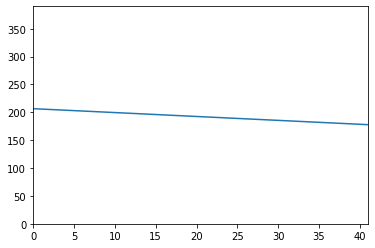

In [70]:
X, Y = points((15,196),(25,189), od.shape[0], od.shape[1], N)
plt.plot(X, Y)
plt.xlim(0, od.shape[0])
plt.ylim(0, od.shape[1])

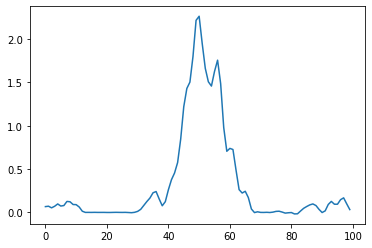

In [72]:
Slice = optical_density(X, Y, grid=False)
plt.plot(Slice)

# Markov Chain Monte Carlo Set Up



## Initial Step Set Up

In [158]:
#creation of the distribution used:
dist = closed_joint_dist_gen(int(N)) #N is the number of pixels in the slice, set globally
#how many chains should we use?
chains = 1
#sample it:
start = dist.sample(chains)
step_size = 0.1

In [154]:
start

[<tf.Tensor: shape=(1,), dtype=float32, numpy=array([48.20665], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([83.11667], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.5822948], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([98.38561], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.5758523], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.63156784], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.19571769], dtype=float32)>,
 <tf.Tensor: shape=(1, 100), dtype=float32, numpy=
 array([[0.15525627, 0.07429612, 0.29699957, 0.46259522, 0.29016054,
         0.82053745, 0.24206746, 0.38797474, 0.14111567, 0.8599329 ,
         0.1481955 , 0.6395867 , 0.74338233, 0.7387494 , 0.62343526,
         0.30039096, 0.2933327 , 0.19507706, 0.3301344 , 0.34572768,
         0.48730493, 0.88718915, 0.41558242, 0.6438122 , 0.2676506 ,
         0.91188586, 0.515144  

In [95]:
original_density = tf.reshape(tf.constant(Slice, dtype=tf.float32), (chains, N))
original_density

<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[ 6.69079572e-02,  7.15010837e-02,  5.27560748e-02,
         7.09116384e-02,  9.75892246e-02,  7.34454766e-02,
         7.91419372e-02,  1.26557812e-01,  1.22855581e-01,
         9.10689533e-02,  8.95035416e-02,  6.18536659e-02,
         1.36956004e-02,  1.15490366e-04,  3.80976446e-04,
         4.39239739e-06,  8.37561034e-04,  7.24822530e-05,
         7.47435188e-05,  2.51912716e-04, -5.52908285e-04,
        -7.03916012e-04,  2.34676569e-04,  9.67155735e-04,
         2.26369448e-04, -1.04150451e-04,  5.64145681e-04,
        -1.27682078e-03, -3.34450253e-03,  9.60482983e-04,
         1.19403619e-02,  3.55237313e-02,  8.05626959e-02,
         1.25617877e-01,  1.65984571e-01,  2.26217926e-01,
         2.40791604e-01,  1.55293062e-01,  7.64923915e-02,
         1.23983361e-01,  2.61320472e-01,  3.77028465e-01,
         4.54105586e-01,  5.74854672e-01,  8.45498979e-01,
         1.21892858e+00,  1.42897558e+00,  1.50237751e+00,
      

Log Prob to minimize

In [151]:
def target_log_prob_tr(*init_state):
  try:
    #print("init st = ", init_state, "\n len init", len(init_state))
    inp = list(init_state)+[original_density]
    return dist.log_prob(inp)
    #print("inp ", inp, "\n", len(inp))
  except Exception as e:
    # print(e)
    inp = list(init_state[0])+[original_density]
    # print(inp)
    try:
      return dist.log_prob(inp)
    except Exception as e:
      print(e)
      print(init_state)
      exit()

In [97]:
#@title Bijectors
# Since HMC operates over unconstrained space, we need to transform the
# samples so they live in real-space.
unconstraining_bijectors = [
    tfp.bijectors.Exp(),       # Maps a positive real to R. for x_tail
    tfp.bijectors.Exp(), # for lambda center
    tfp.bijectors.Exp(), # for lambda left
    tfp.bijectors.Exp(), # for lambda right
    tfp.bijectors.Exp(), # for sigma center
    tfp.bijectors.Exp(), # for sigma left
    tfp.bijectors.Exp(), # for sigma right
    tfp.bijectors.Exp(), # for sigmai
    tfp.bijectors.Exp(), # for amplitude

    # tfp.bijectors.Sigmoid(),       # Maps [0,1] to R. for gamma
    # tfp.bijectors.Sigmoid(),   # Maps [0,1] to R. for delta
    # tfp.bijectors.Exp(),        # Maps a positive real to R. for I0
    # tfp.bijectors.Exp(), # Maps a positive real to R. for R0
    # tfp.bijectors.Sigmoid() # Maps [0,1] to R. for care
]

In [155]:
#@title Initial Step
initial_chain = start[:-1]

In [156]:
#test:
target_log_prob_tr(initial_chain)

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([-355.51163], dtype=float32)>

In [157]:
from google.colab import output
# output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

In [ ]:
#@title Starting MCMC Code
local_runtime = False #@param {type:"boolean"}
# wrap the mcmc sampling call in a @tf.function to speed it up
#@tf.function(autograph=False)
calls = 0
def graph_sample_chain(*args, **kwargs):
  print("current = ",kwargs["current_state"])
  start_time = time.time()
  out = tfp.mcmc.sample_chain(*args, **kwargs)
  print(f"It took: {(time.time()-start_time)/60} min")
  return out
def trace_fn(_, pkr):
    return (
        #pkr.inner_results.inner_results.target_log_prob,
        pkr.inner_results.inner_results.leapfrogs_taken,
        pkr.inner_results.inner_results.has_divergence,
        pkr.inner_results.inner_results.energy,
        pkr.inner_results.inner_results.log_accept_ratio
           )
# r0, gamma, delta, I0, rho, _ = mdl_ols_batch.sample(nchain)
# init_state = [b0, b1]
# # step_size = [tf.cast(i, dtype=dtype) for i in [.1, .1]]
# target_log_prob_fn = lambda *init_state: mdl_ols_batch.log_prob(
#     list(init_state) + [Y_np])
num_burnin_steps = 2500
num_results = 5000



print(step_size)
kernel=tfp.mcmc.TransformedTransitionKernel(
        inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
            target_log_prob_fn=target_log_prob_tr,
            num_leapfrog_steps=2,
            step_size=step_size,
            state_gradients_are_stopped=False),
        bijector=unconstraining_bijectors)

kernel = tfp.mcmc.SimpleStepSizeAdaptation(
    inner_kernel=kernel, num_adaptation_steps=int(num_burnin_steps * 0.8))

#kernel.bootstrap_results(init_state)

# # Sample from the chain.
# [
#     r0_samples,
#     gamma_samples,
#     delta_samples,
#     I0_samples,
#     posterior_care,
# ],
kernel_results = graph_sample_chain(
    num_results=num_results,
    num_burnin_steps=num_burnin_steps,
    current_state=init, #put init in here if you want to start from init
    #previous_kernel_results=kernel.bootstrap_results(initial_chain_state),
    kernel = kernel, parallel_iterations=chains)
#save the kernel_results to drive:
[xtail_samples, lambdac_samples, lambdal_samples, lambdar_samples, sigmac_samples, sigmal_samples, sigmar_samples, sigmai_samples, amplitude_samples], extra = kernel_results
#save data as plain npz files:
base = r"Desktop/covid19/" if local_runtime else r"/content/drive/My Drive/Colab Notebooks/Weld Lab/data/"
output_path = base + f"out/output_run18_{time.strftime('%Y-%m-%d-%H:%M %Z', time.localtime())}.npz"
np.savez(output_path, xtail_samples, lambdac_samples, lambdal_samples, lambdar_samples, sigmac_samples, sigmal_samples, sigmar_samples, sigmai_samples, amplitude_samples)

# notify.send("Finished!")
#np.savez("/content/drive/My Drive/Colab Notebooks/out/output_acceptance.npz", tf.cast(extra.inner_results.inner_results.is_accepted,dtype=tf.float32)).numpy(), extra.inner_results.inner_results.accepted_results.step_size[-100:])
# tau_samples = tf.floor(posterior_care * tf.cast(tf.size(cases),dtype=tf.float32))
output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

tf.Tensor(0.0054721804, shape=(), dtype=float32)
current =  [<tf.Tensor: shape=(1,), dtype=float32, numpy=array([16.54199], dtype=float32)>, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([39.15755], dtype=float32)>, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.8938131], dtype=float32)>, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([91.62796], dtype=float32)>, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.8651632], dtype=float32)>, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.9555118], dtype=float32)>, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.22146982], dtype=float32)>, <tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[0.06649459, 0.17247112, 0.9905001 , 0.15617588, 0.21489641,
        0.15333958, 0.7566374 , 0.8423356 , 0.11635913, 0.28922942,
        0.17449167, 0.8594504 , 0.9338984 , 0.34022266, 0.79693466,
        0.47059858, 0.33562922, 0.18710056, 0.40023452, 0.6165842 ,
        0.6727772 , 0.5651339 , 0.32354206, 0.225649

/usr/local/lib/python3.6/dist-packages/tensorflow_probability/python/mcmc/sample.py:333: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


In [182]:
#@title Calculate Acceptance Rate
print("acceptance rate: {}".format(
    tf.reduce_mean(tf.cast(extra.inner_results.inner_results.is_accepted,dtype=tf.float32))))
print("final step size: {}".format(
    tf.reduce_mean(extra.inner_results.inner_results.accepted_results.step_size[-100:])))
# extra
# step_size = [o[-1] for o in extra.inner_results.inner_results.accepted_results.step_size]
step_size =  tf.reduce_mean(extra.inner_results.inner_results.accepted_results.step_size[-100:])
tf.reduce_mean(extra.inner_results.inner_results.accepted_results.target_log_prob, axis=0)

acceptance rate: 0.4625999927520752
final step size: 0.005472180433571339


<tf.Tensor: shape=(1,), dtype=float32, numpy=array([-148.33812], dtype=float32)>

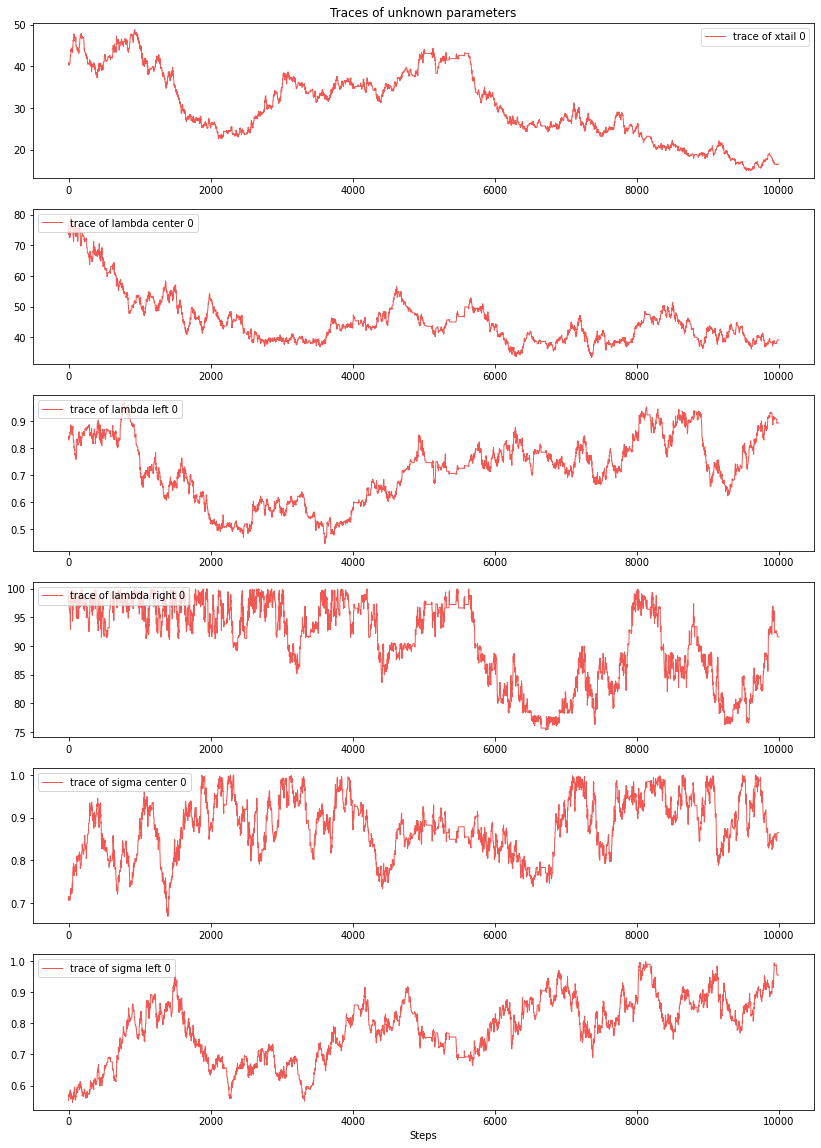

In [183]:
#@title Trace parameters graph
plt.figure(figsize(14, 20))
plt.subplot(611)
lw = 1
nchain = chains

# for pretty colors later in the book.
# xtail_samples
# , 
# lambdac_samples, lambdal_samples, lambdar_samples,
#  sigmac_samples,
#   sigmal_samples, sigmar_samples, sigmai_samples, amplitude_samples]
for i in range(nchain):
  plt.plot(xtail_samples[:, i], label=f"trace of xtail {i}", c=TFColor[i], lw=lw)
plt.title("Traces of unknown parameters")
leg = plt.legend(loc="upper right")
leg.get_frame().set_alpha(0.7)

plt.subplot(612)

for i in range(nchain):
  plt.plot(lambdac_samples[:, i], label=f"trace of lambda center {i}", c=TFColor[i], lw=lw)

plt.legend(loc="upper left")

plt.subplot(613)
for i in range(nchain):
  plt.plot(lambdal_samples[:,i], label=f"trace of lambda left {i}",
     color=TFColor[i], lw=lw)
plt.legend(loc="upper left")

plt.subplot(614)
for i in range(nchain):
  plt.plot(lambdar_samples[:,i], label=f"trace of lambda right {i}",
     color=TFColor[i], lw=lw)
plt.legend(loc="upper left")

plt.subplot(615)
for i in range(nchain):
  plt.plot(sigmac_samples[:,i], label=f"trace of sigma center {i}",
     color=TFColor[i], lw=lw)
plt.legend(loc="upper left")
plt.subplot(616)
for i in range(nchain):
  plt.plot(sigmal_samples[:,i], label=f"trace of sigma left {i}",
     color=TFColor[i], lw=lw)
plt.legend(loc="upper left")
plt.xlabel("Steps")
#plt.ylim(0, 1)
plt.legend()

Recreate the initial data:

In [199]:
#let's find the mean parameters:
amplitude = tf.reduce_mean(amplitude_samples)
sigmas = tf.reduce_mean(sigmai_samples)
sigmar = tf.reduce_mean(sigmar_samples)
sigmal = tf.reduce_mean(sigmal_samples)
sigmac = tf.reduce_mean(sigmac_samples)
lambdar = tf.reduce_mean(lambdar_samples)
lambdal = tf.reduce_mean(lambdal_samples)
lambdac = tf.reduce_mean(lambdac_samples)

simulated_dist = joint_dist_gen(amplitude, sigmas, sigmar, sigmal, sigmac, lambdar, lambdal, lambdac, N)
amplitude

<tf.Tensor: shape=(), dtype=float32, numpy=0.5200003>

In [202]:
init = [
        xtail_samples[-1],
        lambdac_samples[-1],
        lambdal_samples[-1],
        lambdar_samples[-1],
        sigmac_samples[-1],
        sigmal_samples[-1],
        sigmar_samples[-1],
        sigmai_samples[-1],
        amplitude_samples[-1]

]
init

[<tf.Tensor: shape=(1,), dtype=float32, numpy=array([16.54199], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([39.15755], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.8938131], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([91.62796], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.8651632], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.9555118], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.22146982], dtype=float32)>,
 <tf.Tensor: shape=(1, 100), dtype=float32, numpy=
 array([[0.06649459, 0.17247112, 0.9905001 , 0.15617588, 0.21489641,
         0.15333958, 0.7566374 , 0.8423356 , 0.11635913, 0.28922942,
         0.17449167, 0.8594504 , 0.9338984 , 0.34022266, 0.79693466,
         0.47059858, 0.33562922, 0.18710056, 0.40023452, 0.6165842 ,
         0.6727772 , 0.5651339 , 0.32354206, 0.22564912, 0.27666044,
         0.9584269 , 0.65874267,

In [200]:
initial_chain

[<tf.Tensor: shape=(1,), dtype=float32, numpy=array([48.20665], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([83.11667], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.5822948], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([98.38561], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.5758523], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.63156784], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.19571769], dtype=float32)>,
 <tf.Tensor: shape=(1, 100), dtype=float32, numpy=
 array([[0.15525627, 0.07429612, 0.29699957, 0.46259522, 0.29016054,
         0.82053745, 0.24206746, 0.38797474, 0.14111567, 0.8599329 ,
         0.1481955 , 0.6395867 , 0.74338233, 0.7387494 , 0.62343526,
         0.30039096, 0.2933327 , 0.19507706, 0.3301344 , 0.34572768,
         0.48730493, 0.88718915, 0.41558242, 0.6438122 , 0.2676506 ,
         0.91188586, 0.515144  

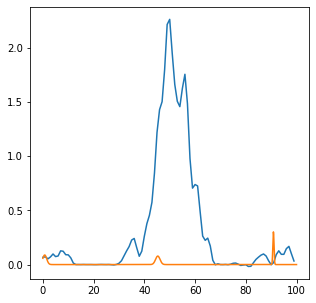

In [198]:
plt.figure(figsize=(5,5))
# plt.plot(simulated_dist.sample())
plt.plot(Slice)
mg = main_gaussian(sigmar, sigmal, sigmac, lambdar, lambdal, lambdac)
x = np.linspace(0, N*1., 1000)
plt.plot(x, mg.prob(x)*amplitude)